In [146]:
#CNN TEST
import numpy as np
from scipy.signal import convolve2d
# to read an image from a url
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
import torchvision.transforms as T
from PIL import Image
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,TensorDataset
import warnings
warnings.filterwarnings('ignore')

In [148]:
# Define transform to normalize data
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))  # Mean and std deviation for MNIST
])
# Load MNIST dataset with transformations
train_dataset = MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=False, transform=transform)

In [150]:
# reduce size of datasets
train_size = int(0.05 * len(train_dataset))
test_size = int(0.05 * len(test_dataset))

# Create reduced and normalized datasets
train_data_reduced = train_dataset.data[:train_size].float() / 255.0
train_labels_reduced = train_dataset.targets[:train_size].long()

test_data_reduced = test_dataset.data[:test_size].float() / 255.0
test_labels_reduced = test_dataset.targets[:test_size].long()

In [152]:
train_data = train_data_reduced.reshape(train_data_reduced.shape[0],1,28,28)

In [154]:
test_data= test_data_reduced.reshape(test_data_reduced.shape[0],1,28,28)

In [156]:
train_data.shape

torch.Size([3000, 1, 28, 28])

In [158]:
test_data.shape

torch.Size([500, 1, 28, 28])

In [160]:
# convert to tensor
train_data   = torch.tensor( train_data ).float()
train_label = torch.tensor( train_labels_reduced ).long()

# pyTorch conversion
train_data = TensorDataset(train_data,train_label)
test_data  = TensorDataset(test_data,test_labels_reduced)

# dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [162]:
# size check (images, channels,  width,  height)
train_loader.dataset.tensors[0].shape

torch.Size([3000, 1, 28, 28])

In [307]:
# create a class for the model
def createNNmodel(printtoggle=False):
    
  class testNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()  #for parent class
      ### convolution layers
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)
      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)
      # compute the number of units in FClayer: size of 
        #FC input calculated based on size of output of conv2 after maxpool
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, 0 or 1
      expectSize = 20*int(expectSize**2)
      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)
      ### output layer
      self.out = nn.Linear(50,10)

      # flag to print shape of tensors during forward pass
      self.print = printtoggle

    # forward pass
    def forward(self,x):
      if self.print:
            print(f'Input: {x.shape}')
      # convolution -> maxpool -> relu
      conv1act = F.relu(self.conv1(x))
      x = F.max_pool2d(conv1act,2)
      if self.print:
            print(f'Layer conv1/pool1: {x.shape}')
      # convolution -> maxpool -> relu
      conv2act = F.relu(self.conv2(x))
      x = F.max_pool2d(conv2act, 2)
      if self.print:
            print(f'Layer conv2/pool2: {x.shape}') 
          
      # reshape for linear layer
      nUnits = x.shape.numel() // x.shape[0]
      x = x.view(-1, int(nUnits))
      if self.print:
            print(f'Vectorize: {x.shape}')
        # linear layers
      x = F.relu(self.fc1(x))
      if self.print:
           print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print:
          print(f'Layer out: {x.shape}')
      return x,conv1act,conv2act

  # create the model instance
  net = testNet(printtoggle=False)
  # loss function for classification
  lossfun = nn.CrossEntropyLoss()
  #lossfun = nn.BCEWithLogitsLoss()
  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

  return net,lossfun,optimizer

In [309]:
#one batch test
net,lossfun,optimizer = createNNmodel(True)

X,y = next(iter(train_loader))
yHat,featmap1,featmap2 = net(X)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)


#compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

Predicted category:
torch.Size([32, 10])

Feature map after conv1
torch.Size([32, 10, 26, 26])

Feature map after conv2
torch.Size([32, 20, 11, 11])
 
Loss:
tensor(2.3076, grad_fn=<NllLossBackward0>)
 
torch.Size([32, 10])
torch.Size([32])


In [311]:
summary(net,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [313]:
def model_train():

  # number of epochs
  numepochs = 15

  # create a new model
  net,lossfun,optimizer = createNNmodel()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs
  for epochs in range(numepochs):
    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
     # forward pass and loss
      yHat_tuple = net(X)
      yHat = yHat_tuple[0]  # Extract logits
      loss = lossfun(yHat, y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # loss from this batch
      batchLoss.append(loss.item())
      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    #  get ave training accuracy
    trainAcc.append( np.mean(batchAcc) )
    # and get average losses across the batches
    losses[epochs] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat_tuple = net(X)
      yHat = yHat_tuple[0]  # Extract logits

    # compare with training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs
  # function output
  return trainAcc,testAcc,losses,net

In [315]:
trainAcc,testAcc,losses,net = model_train();

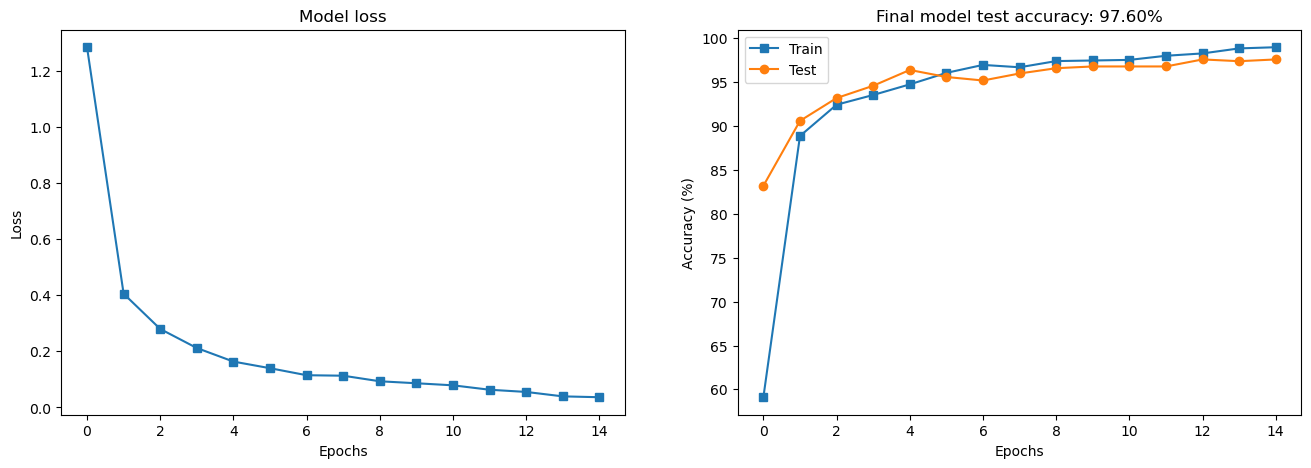

In [317]:
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

Visualizing conv1 filters:


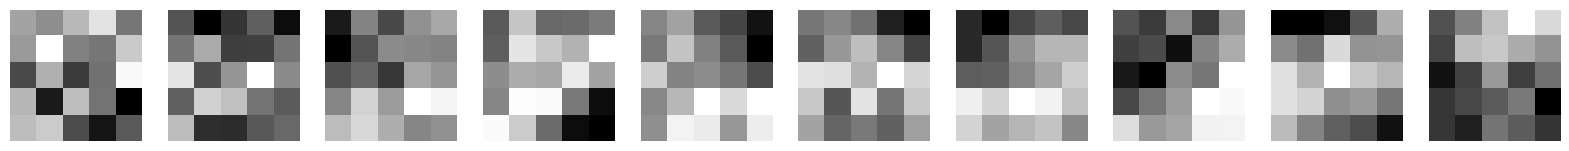

Visualizing conv2 filters:


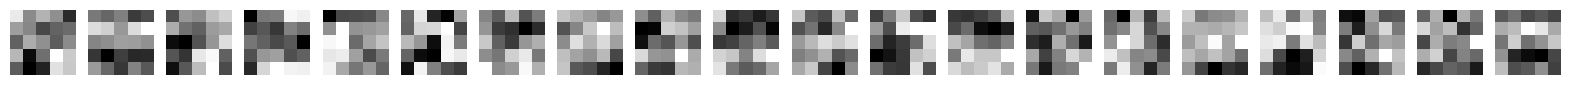

Shape of conv1 weights: torch.Size([10, 1, 5, 5])
Shape of conv2 weights: torch.Size([20, 10, 5, 5])


In [319]:
#filter visualization for convolution layer
def visualize_filters(layer, num_filters):
    filters = layer.weight.data.cpu().numpy()  # convert to numpy array

    fig, axes = plt.subplots(1, num_filters, figsize=(20, 5))
    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(filters[i, 0, :, :], cmap='gray')
        ax.axis('off')
    plt.show()

# Visualize the filters of the first convolutional layer
print("Visualizing conv1 filters:")
visualize_filters(net.conv1, 10)

# Visualize the filters of the second convolutional layer
print("Visualizing conv2 filters:")
visualize_filters(net.conv2, 20)
conv1_shape = net.conv1.weight.shape
print("Shape of conv1 weights:", conv1_shape)
# Accessing the shape of conv2 weights
conv2_shape = net.conv2.weight.shape
print("Shape of conv2 weights:", conv2_shape)

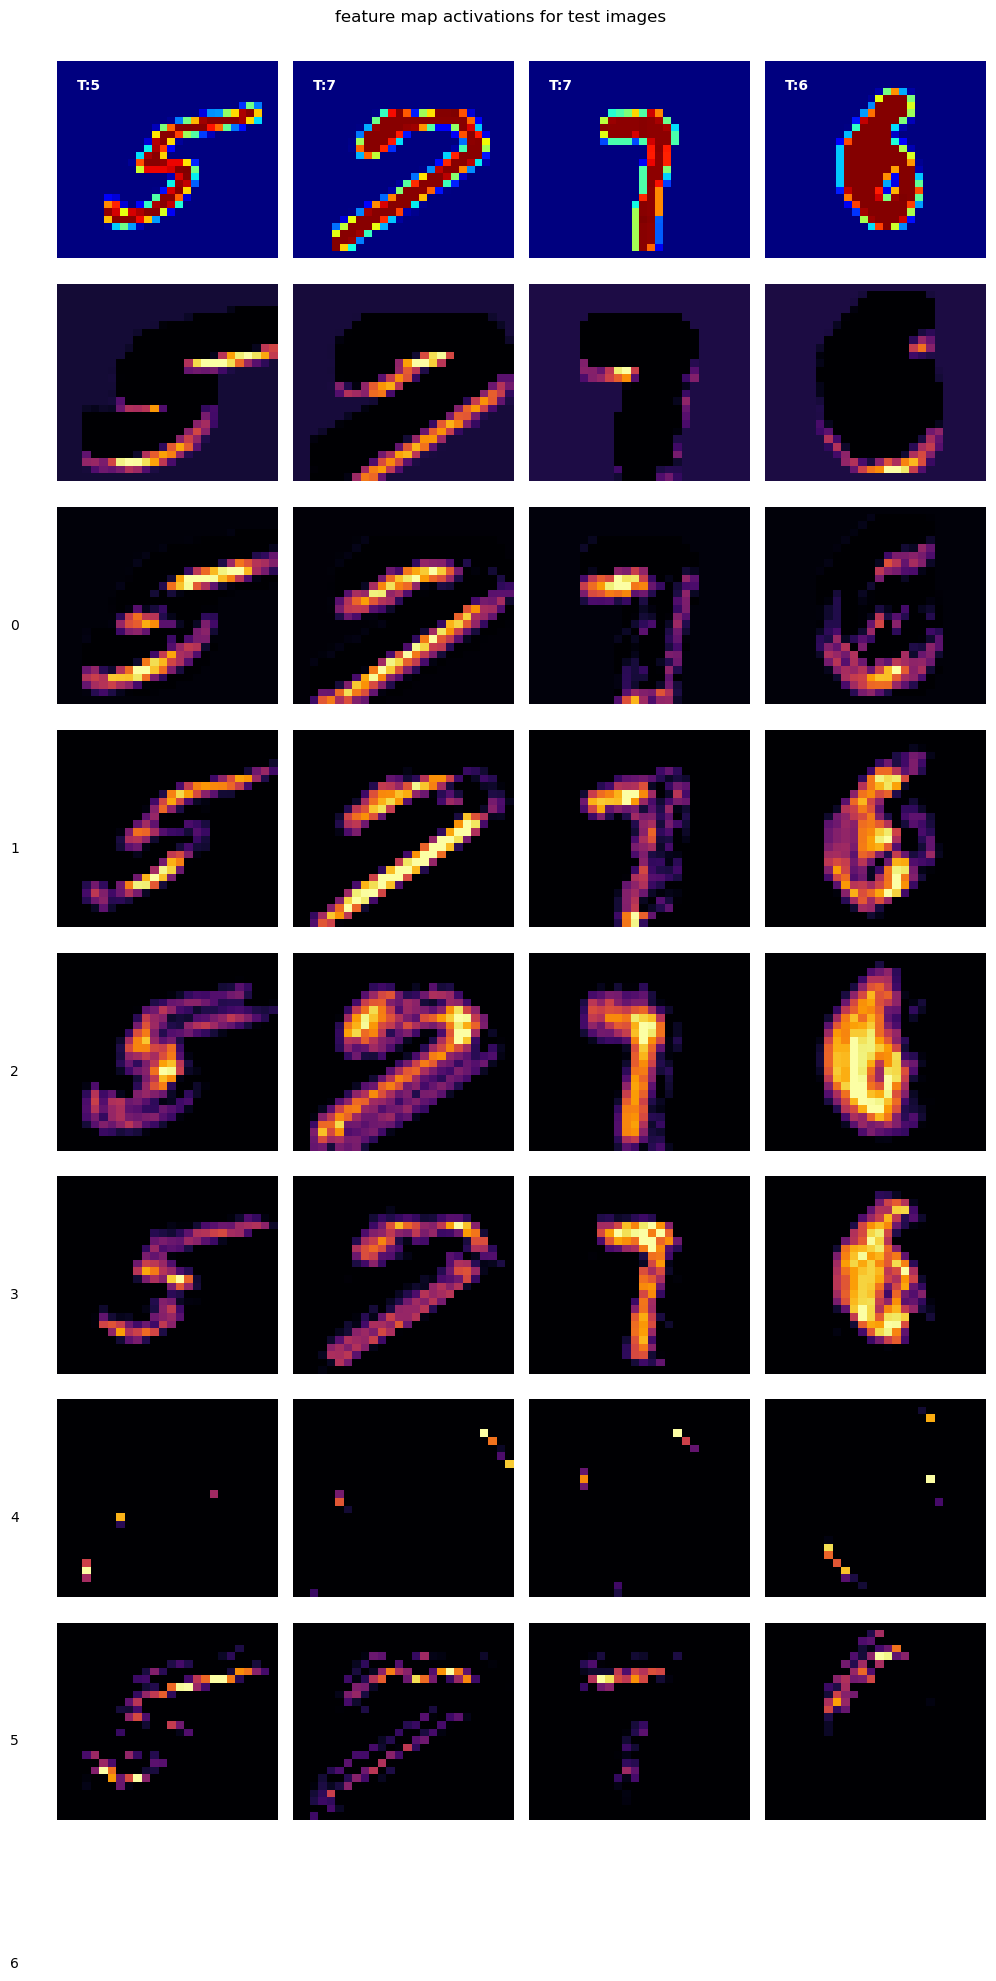

In [335]:
#access feature maps from the conv1 layer
fig,axs = plt.subplots(8,4,figsize=(10,18))

for pic in range(4):
  # show the original picture
  img = X[pic,0,:,:].detach()
  axs[0,pic].imshow(img,cmap='jet',vmin=0,vmax=1, aspect='auto')
  axs[0,pic].axis('off')
  axs[0,pic].text(2,2,'T:%s'%int(y[pic].item()),ha='left',va='top',color='w',fontweight='bold')

  for feat in range(7):
    # extract the feature map from this image
    img = featmap1[pic,feat,:,:].detach()
    axs[feat+1,pic].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9, aspect='auto')
    axs[feat+1,pic].axis('off')
    axs[feat+1,pic].text(-5,45,feat,ha='right') if pic==0 else None
plt.subplots_adjust(left=0.1, right=0.9, top=0.1, bottom=0.05, hspace=0.1, wspace=0.1)
plt.tight_layout()
plt.suptitle('feature map activations for test images',x=.5,y=1.02)
plt.show()